In [2]:
import os
import soundfile as sf
import numpy as np
import noisereduce as nr
import matplotlib.pyplot as plt

In [3]:
def reduce_noise_with_profile(input_file, output_file, noise_profile_file="last_0.5"):
    # Load the noisy input audio
    data, rate = sf.read(input_file)

    if os.path.exists(noise_profile_file):
        noise_profile, _ = sf.read(noise_profile_file)
    else:
        try:
            part, seconds = noise_profile_file.split("_")
            seconds = float(seconds)
            sample_count = int(seconds * rate)
            if part == "first":
                noise_profile = data[:sample_count]
            elif part == "last":
                noise_profile = data[-sample_count:]
            else:
                raise ValueError(f"Invalid keyword '{part}', expected 'first' or 'last'")
        except Exception as e:
            raise ValueError(f"Invalid noise_profile_file value: {noise_profile_file}") from e

    # Apply noise reduction
    reduced_noise = nr.reduce_noise(y=data, y_noise=noise_profile, sr=rate)

    # Save the result
    sf.write(output_file, reduced_noise, rate)

In [4]:
input_file = r"C:\Users\User_1\Desktop\noisy_fish.wav"
output_file = r"C:\Users\User_1\Desktop\output_2.wav"


input_file = reduce_noise_with_profile(input_file, output_file, noise_profile_file="last_0.5")

In [5]:
def reduce_noise_with_profile(input_file, output_file, noise_profile_file="last_0.5",
                              silence_threshold=0.01, min_silence_duration=0.3, visualization=False):
    """
    Reduces noise in an audio file using a noise profile.

    Args:
        input_file (str): Path to the noisy input audio file.
        output_file (str): Path to save the denoised output.
        noise_profile_file (str): Either a path to a noise file, or a keyword like 'first_1.0', 'last_0.5', or 'adaptive'.
        silence_threshold (float): RMS energy below which audio is considered silent (used for 'adaptive').
        min_silence_duration (float): Minimum duration (in seconds) to consider a segment as valid noise for 'adaptive'.
        visualization (bool): If True, shows a plot of the waveform with the detected noise profile region highlighted.
    """
    # Load the noisy input audio
    data, rate = sf.read(input_file)
    total_samples = len(data)

    if len(data.shape) > 1:
        data = np.mean(data, axis=1)  # convert stereo to mono

    # Initialize visualization parameters
    noise_start_sample = None
    noise_end_sample = None

    # Detect noise profile
    if os.path.exists(noise_profile_file):
        noise_profile, _ = sf.read(noise_profile_file)
        noise_start_sample = 0
        noise_end_sample = len(noise_profile)
    elif noise_profile_file.startswith("first_") or noise_profile_file.startswith("last_"):
        try:
            part, seconds = noise_profile_file.split("_")
            seconds = float(seconds)
            sample_count = int(seconds * rate)
            if part == "first":
                noise_start_sample = 0
                noise_end_sample = sample_count
                noise_profile = data[:sample_count]
            elif part == "last":
                noise_start_sample = total_samples - sample_count
                noise_end_sample = total_samples
                noise_profile = data[-sample_count:]
            else:
                raise ValueError(f"Invalid keyword '{part}', expected 'first' or 'last'")
        except Exception as e:
            raise ValueError(f"Invalid noise_profile_file value: {noise_profile_file}") from e
    elif noise_profile_file == "adaptive":
        # Sliding window RMS energy analysis
        window_size = int(0.05 * rate)  # 50ms
        stride = window_size // 2
        min_samples = int(min_silence_duration * rate)
        best_start = None
        best_length = 0

        i = 0
        while i < len(data) - window_size:
            window = data[i:i + window_size]
            rms = np.sqrt(np.mean(window**2))
            if rms < silence_threshold:
                start = i
                while i < len(data) - window_size:
                    window = data[i:i + window_size]
                    rms = np.sqrt(np.mean(window**2))
                    if rms >= silence_threshold:
                        break
                    i += stride
                end = i
                if end - start > best_length and (end - start) >= min_samples:
                    best_start = start
                    best_length = end - start
            else:
                i += stride

        if best_start is not None:
            noise_start_sample = best_start
            noise_end_sample = best_start + best_length
            noise_profile = data[noise_start_sample:noise_end_sample]
        else:
            raise ValueError("Could not find a low-energy segment for adaptive noise profiling.")
    else:
        raise ValueError(f"Invalid noise_profile_file value: {noise_profile_file}")

    # Visualization
    if visualization:
        times = np.linspace(0, len(data) / rate, num=len(data))
        fig, ax = plt.subplots(figsize=(16, 4))
        ax.plot(times, data, label="Original Audio", alpha=0.6)
        if noise_start_sample is not None and noise_end_sample is not None:
            ax.axvspan(noise_start_sample / rate, noise_end_sample / rate, color='red', alpha=0.3, label="Noise Profile")
        ax.set_title("Audio Signal with Detected Noise Profile")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        ax.legend()
        plt.tight_layout()
        plt.show()

    # Apply noise reduction
    reduced_noise = nr.reduce_noise(y=data, y_noise=noise_profile, sr=rate)

    # Save the result
    sf.write(output_file, reduced_noise, rate)


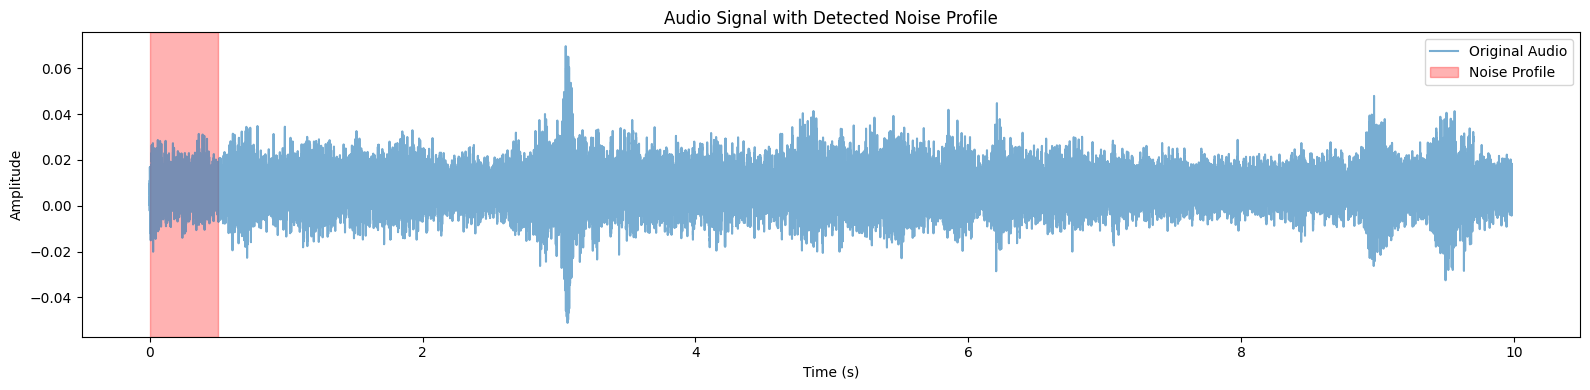

In [9]:
input_file = r"C:\Users\User_1\Desktop\noisy_fish.wav"
input_file = r"D:\Git_repos\Noise_reduction_repos\DeepNoiseReducer\noisy_auido_files\Comm1.mp3"
input_file = r"D:\Git_repos\Noise_reduction_repos\DeepNoiseReducer\raw_1.wav"
output_file = r"C:\Users\User_1\Desktop\output_2.wav"


input_file = reduce_noise_with_profile(input_file, output_file, noise_profile_file="first_0.5",
                                       silence_threshold=0.01, min_silence_duration=2, visualization=True)